## OMLDS End-to-End Machine Learning Project

### Kaggle Credit Fraud Detection Dataset
### Source: https://www.kaggle.com/datasets/kartik2112/fraud-detection

### Date: 09/13/2023

#### Objective

The main objective in this notebook is creating an engineered feature, distance, based on the provided location data of the buyer and merchant.


#### Feature Engineering steps:

1.  Prior to feature engineering it is assumed you've gotten familier with the 
    data via EDA (exploratory data anaylsis)

2.  With latitude and longitude for buyer and merchant in the dataset, it was 
    reasonable to create a distance calculation.

3.  While creating this new feature, we evaluate it again with EDA techniques to
    determine if it is a usefule feature and if it leads us to additional 
    engineered features or different methods of calculation.



In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import googlemaps
import os 
from haversine import haversine, Unit
from dython.nominal import (identify_nominal_columns, associations)

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (20, 16)

### Read in training dataset

If from your personal google drive use this code.  You need your google credentials.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_raw = pd.read_csv(
    '/content/drive/MyDrive/kaggle_credit_fraud_detection/fraudTrain.csv', 
    index_col=0, 
    parse_dates = ["trans_date_trans_time", "dob"]
)

Or use local copy stored in ../data folder

In [2]:
df_raw = pd.read_csv('../data/fraudTrain.csv', index_col=0, parse_dates = ["trans_date_trans_time", "dob"])


In [3]:
# retrieve R library geocoding by city state
df_buyer_city_state = pd.read_csv('../data/new_home_coords.csv')
df_buyer_city_state.rename(
    columns={
        "address": "city_state", 
        "lat_home":"buyer_city_state_lat",
        "long_home":"buyer_city_state_long"},
    inplace=True
    )
df_buyer_city_state["buyer_city_state_location"] = df_buyer_city_state[
    ["buyer_city_state_lat", "buyer_city_state_long"]].apply(tuple, axis=1)
df_buyer_city_state.head()

,city_state,buyer_city_state_lat,buyer_city_state_long,buyer_city_state_location
0,"Medford, NY",40.817599,-73.000107,"(40.8175985, -73.0001068)"
1,"Norfolk, VA",36.844835,-76.286400,"(36.8448348, -76.2863999)"
2,"Oakton, VA",38.896729,-77.298697,"(38.896729, -77.29869697995693)"
3,"Moss Point, MS",30.411588,-88.534460,"(30.4115881, -88.5344601)"
4,"Freeport, ME",43.857307,-70.103760,"(43.857307, -70.10376)"


In [4]:
# convert the unix_time to datetime
df_raw["converted_unix_time"] = pd.to_datetime(df_raw["unix_time"],unit='s')

In [5]:
# data type info
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   first                  1296675 non-null  object        
 6   last                   1296675 non-null  object        
 7   gender                 1296675 non-null  object        
 8   street                 1296675 non-null  object        
 9   city                   1296675 non-null  object        
 10  state                  1296675 non-null  object        
 11  zip                    1296675 non-null  int64         
 12  lat                    12966

### Distance feature calculation
Below section shows logic to create an engineered feature, "distance", using the haversine formula for shortest distance betwen two points on a sphere (globe).

Uses additional libraries:  
1. ```pip install haversine``` 
2. ```pip install dython```

In [ ]:
# use these installs if running in Google Colab
# # install haversine library
# !pip install haversine
# # install dython library
# !pip install dython

For ease of use in this example, make a copy of just the columns we need to calculate distances.


In [24]:
df_locs = df_raw[["trans_num", "is_fraud", "cc_num","lat","long", "merch_lat","merch_long","street", "city","state","zip"]]
df_locs.rename(columns={"lat": "buyer_lat", "long":"buyer_long"}, inplace=True)

The haversine library for calculating distance takes tuples of latitude, longitude as input.
Create new columns for buyer and merchant locations.

In [26]:
df_locs["buyer_location"] = df_locs[["buyer_lat", "buyer_long"]].apply(tuple, axis=1)
df_locs["merchant_location"] = df_locs[["merch_lat", "merch_long"]].apply(tuple, axis=1)

In [27]:
df_locs["city_state"] = df_locs["city"] +", " + df_locs["state"]

In [28]:
df_locs.head()

,trans_num,is_fraud,cc_num,buyer_lat,buyer_long,merch_lat,merch_long,street,city,state,zip,buyer_location,merchant_location,city_state
0,0b242abb623afc578575680df30655b9,0,2703186189652095,36.0788,-81.1781,36.011293,-82.048315,561 Perry Cove,Moravian Falls,NC,28654,"(36.0788, -81.1781)","(36.011293, -82.048315)","Moravian Falls, NC"
1,1f76529f8574734946361c461b024d99,0,630423337322,48.8878,-118.2105,49.159047,-118.186462,43039 Riley Greens Suite 393,Orient,WA,99160,"(48.8878, -118.2105)","(49.159047, -118.186462)","Orient, WA"
2,a1a22d70485983eac12b5b88dad1cf95,0,38859492057661,42.1808,-112.2620,43.150704,-112.154481,594 White Dale Suite 530,Malad City,ID,83252,"(42.1808, -112.262)","(43.150704, -112.154481)","Malad City, ID"
3,6b849c168bdad6f867558c3793159a81,0,3534093764340240,46.2306,-112.1138,47.034331,-112.561071,9443 Cynthia Court Apt. 038,Boulder,MT,59632,"(46.2306, -112.1138)","(47.034331, -112.561071)","Boulder, MT"
4,a41d7549acf90789359a9aa5346dcb46,0,375534208663984,38.4207,-79.4629,38.674999,-78.632459,408 Bradley Rest,Doe Hill,VA,24433,"(38.4207, -79.4629)","(38.674999, -78.632459)","Doe Hill, VA"


In [29]:
# Merge in the city_state based location data
df_locs = pd.merge( 
    left=df_locs, 
    right=df_buyer_city_state,
    how="left",
    left_on="city_state",
    right_on="city_state")

In [30]:
df_locs.head()

,trans_num,is_fraud,cc_num,buyer_lat,buyer_long,merch_lat,merch_long,street,city,state,zip,buyer_location,merchant_location,city_state,buyer_city_state_lat,buyer_city_state_long,buyer_city_state_location
0,0b242abb623afc578575680df30655b9,0,2703186189652095,36.0788,-81.1781,36.011293,-82.048315,561 Perry Cove,Moravian Falls,NC,28654,"(36.0788, -81.1781)","(36.011293, -82.048315)","Moravian Falls, NC",36.102686,-81.181582,"(36.1026865, -81.18158238008564)"
1,1f76529f8574734946361c461b024d99,0,630423337322,48.8878,-118.2105,49.159047,-118.186462,43039 Riley Greens Suite 393,Orient,WA,99160,"(48.8878, -118.2105)","(49.159047, -118.186462)","Orient, WA",41.203103,-94.416518,"(41.2031032, -94.4165181)"
2,a1a22d70485983eac12b5b88dad1cf95,0,38859492057661,42.1808,-112.2620,43.150704,-112.154481,594 White Dale Suite 530,Malad City,ID,83252,"(42.1808, -112.262)","(43.150704, -112.154481)","Malad City, ID",42.191587,-112.250798,"(42.1915872, -112.250798)"
3,6b849c168bdad6f867558c3793159a81,0,3534093764340240,46.2306,-112.1138,47.034331,-112.561071,9443 Cynthia Court Apt. 038,Boulder,MT,59632,"(46.2306, -112.1138)","(47.034331, -112.561071)","Boulder, MT",46.236595,-112.120834,"(46.236595, -112.120834)"
4,a41d7549acf90789359a9aa5346dcb46,0,375534208663984,38.4207,-79.4629,38.674999,-78.632459,408 Bradley Rest,Doe Hill,VA,24433,"(38.4207, -79.4629)","(38.674999, -78.632459)","Doe Hill, VA",38.387066,-79.520324,"(38.3870661, -79.5203237)"


In [31]:
df_locs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   trans_num                  1296675 non-null  object 
 1   is_fraud                   1296675 non-null  int64  
 2   cc_num                     1296675 non-null  int64  
 3   buyer_lat                  1296675 non-null  float64
 4   buyer_long                 1296675 non-null  float64
 5   merch_lat                  1296675 non-null  float64
 6   merch_long                 1296675 non-null  float64
 7   street                     1296675 non-null  object 
 8   city                       1296675 non-null  object 
 9   state                      1296675 non-null  object 
 10  zip                        1296675 non-null  int64  
 11  buyer_location             1296675 non-null  object 
 12  merchant_location          1296675 non-null  object 
 13  city_state  

Create a function to enabling the calculation on all the rows of our dataset

In [ ]:
def calc_distance(row):
  """Calculates the haversine distance between two geopoints (tuples of latitude, longitude) in miles, rounded to 2 decimals."""
  return round((haversine(row["buyer_location"], row["merchant_location"], unit=Unit.MILES)),2)

In [ ]:
df_locs["distance_buyer_merch"] = df_locs.apply(calc_distance, axis=1)

In [32]:
def calc_distance_2(loc1_col, loc2_col):
  """Calculates the haversine distance between two geopoints (tuples of latitude, longitude) in miles, rounded to 2 decimals."""
  return round((haversine(loc1_col, loc2_col, unit=Unit.MILES)),2)

In [33]:
df_locs["distance_buyer_merch"] = df_locs.apply(lambda x: calc_distance_2(x["buyer_location"], x["merchant_location"]), axis=1)

In [34]:
df_locs["distance_buyer_city_state_merch"] = df_locs.apply(lambda x: calc_distance_2(x["buyer_city_state_location"],x["merchant_location"]), axis=1)

In [35]:
df_locs.head()

,trans_num,is_fraud,cc_num,buyer_lat,buyer_long,merch_lat,merch_long,street,city,state,zip,buyer_location,merchant_location,city_state,buyer_city_state_lat,buyer_city_state_long,buyer_city_state_location,distance_buyer_merch,distance_buyer_city_state_merch
0,0b242abb623afc578575680df30655b9,0,2703186189652095,36.0788,-81.1781,36.011293,-82.048315,561 Perry Cove,Moravian Falls,NC,28654,"(36.0788, -81.1781)","(36.011293, -82.048315)","Moravian Falls, NC",36.102686,-81.181582,"(36.1026865, -81.18158238008564)",48.84,48.82
1,1f76529f8574734946361c461b024d99,0,630423337322,48.8878,-118.2105,49.159047,-118.186462,43039 Riley Greens Suite 393,Orient,WA,99160,"(48.8878, -118.2105)","(49.159047, -118.186462)","Orient, WA",41.203103,-94.416518,"(41.2031032, -94.4165181)",18.77,1274.32
2,a1a22d70485983eac12b5b88dad1cf95,0,38859492057661,42.1808,-112.2620,43.150704,-112.154481,594 White Dale Suite 530,Malad City,ID,83252,"(42.1808, -112.262)","(43.150704, -112.154481)","Malad City, ID",42.191587,-112.250798,"(42.1915872, -112.250798)",67.24,66.45
3,6b849c168bdad6f867558c3793159a81,0,3534093764340240,46.2306,-112.1138,47.034331,-112.561071,9443 Cynthia Court Apt. 038,Boulder,MT,59632,"(46.2306, -112.1138)","(47.034331, -112.561071)","Boulder, MT",46.236595,-112.120834,"(46.236595, -112.120834)",59.45,58.94
4,a41d7549acf90789359a9aa5346dcb46,0,375534208663984,38.4207,-79.4629,38.674999,-78.632459,408 Bradley Rest,Doe Hill,VA,24433,"(38.4207, -79.4629)","(38.674999, -78.632459)","Doe Hill, VA",38.387066,-79.520324,"(38.3870661, -79.5203237)",48.19,51.95


array([[<Axes: title={'center': 'distance_buyer_merch'}>,
        <Axes: title={'center': 'distance_buyer_city_state_merch'}>]],
      dtype=object)

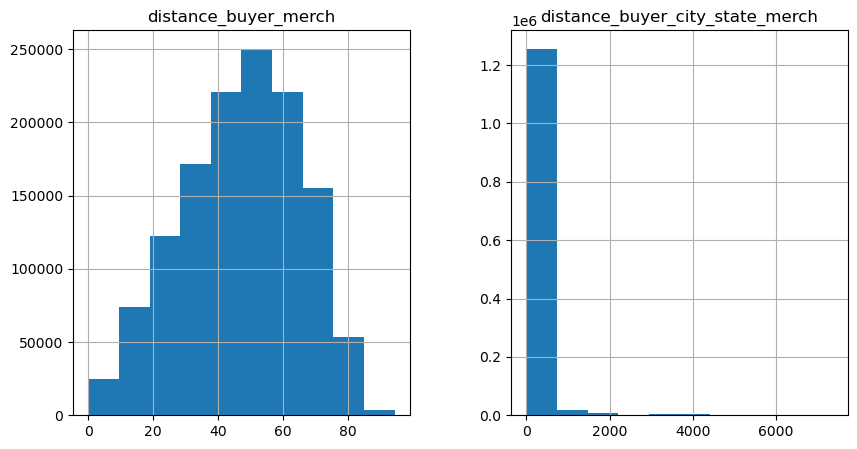

In [36]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
df_locs[["distance_buyer_merch", "distance_buyer_city_state_merch"]].hist(ax=ax)

Text(0.5, 1.0, 'Correlation Heatmap')

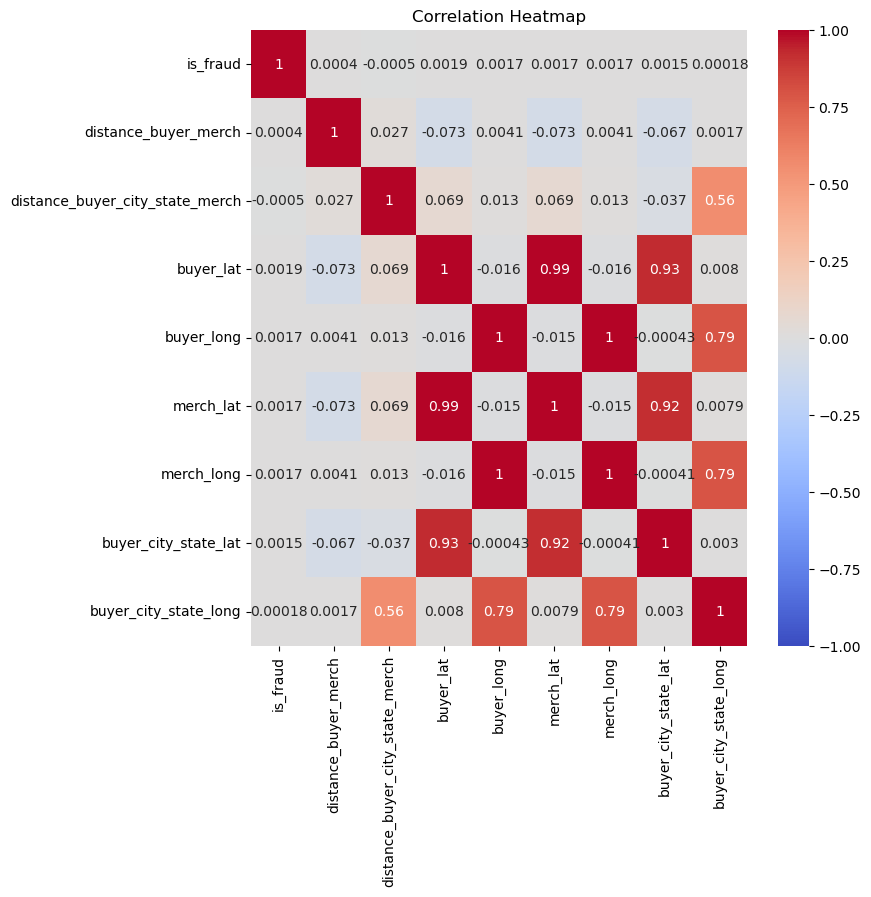

In [74]:


plt.rcParams['figure.figsize'] = (8, 8)

dist_corr = df_locs[
    ["is_fraud", 
     "distance_buyer_merch", 
     "distance_buyer_city_state_merch",
     "buyer_lat", "buyer_long",
     "merch_lat", "merch_long",
     "buyer_city_state_lat", "buyer_city_state_long"
]].corr()
mask = np.triu(np.ones_like(dist_corr, dtype=bool))
heatmap = sns.heatmap(
    dist_corr, 
    vmin=-1.0, 
    vmax=1.0, 
    cmap="coolwarm",
    # mask=mask,
    annot=True)
heatmap.set_title("Correlation Heatmap")

### Geocoding addresses

We're going to follow a geocoding guide by Peter Haas published [here](https://peterhaas-me.medium.com/how-to-geocode-with-python-and-pandas-4cd1d717d3f7) on Medium to geocode the 
addresses in our dataset.

You'll need install the geopy library:   ```pip install geopy```

In [37]:
from geopy.geocoders import Nominatim  # OpenStreetMaps geocoding service
from geopy import distance  # distance calculation built into geopy library
from geopy.extra.rate_limiter import RateLimiter # To limit service request rates per provider terms (Nominatum is 1/sec)

Create instances of the geocoding classes that enable applying the service to a dataframe.  We need to limit the API call rate to be compliant with the service terms.

In [38]:
geolocator = Nominatim(timeout=10, user_agent="OMLDS_test")
geocode = RateLimiter(
    geolocator.geocode, 
    min_delay_seconds=1, 
    max_retries=2, 
    error_wait_seconds=5.0, 
    swallow_exceptions=True,
    return_value_on_exception=None
    )

Since addresses are supposed to be unique per cc_num, we don't need to call geocoding on all transactions, only unique cc_num/address combinations.  This will greatly reduce the number of geocoding calls (983 instead of 1M+).

In [62]:
df_geocode = df_raw[["cc_num", "street", "city", "state", "zip"]].copy()

In [63]:
df_geocode.drop_duplicates(inplace=True)

In [64]:
df_geocode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 1275589
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cc_num  983 non-null    int64 
 1   street  983 non-null    object
 2   city    983 non-null    object
 3   state   983 non-null    object
 4   zip     983 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 46.1+ KB


In the case of this simulated dataset the full address is not real.  Therefore we are limited to use city, state to retrieve a geocode.

In [65]:
# add columns for city_state and full_address used in geocoding
# because this is a simulated public training dataset the full addresses are not real
# we can however use the city and state as an approximation of location aside from the given lat/long

# df_cc_address["full_address"] = df_cc_address.street + "," + df_cc_address.city + "," + df_cc_address.state #+ ", " + str(df_cc_address.zip)

# This geocoding service requires city,state with no spaces
df_geocode["city_state"] = df_geocode.city +","+df_geocode.state


In [66]:
df_geocode.head()

,cc_num,street,city,state,zip,city_state
0,2703186189652095,561 Perry Cove,Moravian Falls,NC,28654,"Moravian Falls,NC"
1,630423337322,43039 Riley Greens Suite 393,Orient,WA,99160,"Orient,WA"
2,38859492057661,594 White Dale Suite 530,Malad City,ID,83252,"Malad City,ID"
3,3534093764340240,9443 Cynthia Court Apt. 038,Boulder,MT,59632,"Boulder,MT"
4,375534208663984,408 Bradley Rest,Doe Hill,VA,24433,"Doe Hill,VA"


Running the free geocoding service is limited to 1 call per second.  For the full set of unique city-states we need approx. 16 min.  We'll use a small test set to show how the call works.  The file is saved as geocode_city_state.csv

In [60]:
# df_geocode["geocode"] = df_geocode["city_state"].apply(geocode)

In [67]:
df_geocode_sample = df_geocode.sample(n=5, random_state=42)

In [68]:
df_geocode_sample.head()

,cc_num,street,city,state,zip,city_state
2772,4390966588600992777,8149 Harris Divide,Oklahoma City,OK,73134,"Oklahoma City,OK"
2648,4178097073221156,639 Cruz Islands,Baroda,MI,49101,"Baroda,MI"
2821,213186334552049,37426 Olson Villages,Irvine,PA,16329,"Irvine,PA"
801,4561546772499,7118 Jessica Unions Apt. 789,Moriarty,NM,87035,"Moriarty,NM"
69,2248735346244816,29156 Mark Park Apt. 108,Utica,KS,67584,"Utica,KS"


In [69]:
df_geocode_sample["geocode"] = df_geocode_sample["city_state"].apply(geocode)

In [71]:
df_geocode_sample.head()

,cc_num,street,city,state,zip,city_state,geocode
2772,4390966588600992777,8149 Harris Divide,Oklahoma City,OK,73134,"Oklahoma City,OK","(Oklahoma City, Oklahoma County, Oklahoma, Uni..."
2648,4178097073221156,639 Cruz Islands,Baroda,MI,49101,"Baroda,MI","(Baroda, Baroda Township, Berrien County, Mich..."
2821,213186334552049,37426 Olson Villages,Irvine,PA,16329,"Irvine,PA","(Irvine, Brokenstraw Township, Warren County, ..."
801,4561546772499,7118 Jessica Unions Apt. 789,Moriarty,NM,87035,"Moriarty,NM","(Moriarty, Torrance County, New Mexico, 87035,..."
69,2248735346244816,29156 Mark Park Apt. 108,Utica,KS,67584,"Utica,KS","(Utica, Ness County, Kansas, United States, (3..."


Extract the latitude and longitude info from the geocode object to new fields

In [72]:
df_geocode_sample["geocode_city_state_lat"] = [g.latitude for g in df_geocode_sample.geocode]
df_geocode_sample["geocode_city_state_long"] = [g.longitude for g in df_geocode_sample.geocode]

In [73]:
df_geocode_sample.head()

,cc_num,street,city,state,zip,city_state,geocode,geocode_city_state_lat,geocode_city_state_long
2772,4390966588600992777,8149 Harris Divide,Oklahoma City,OK,73134,"Oklahoma City,OK","(Oklahoma City, Oklahoma County, Oklahoma, Uni...",35.472989,-97.517054
2648,4178097073221156,639 Cruz Islands,Baroda,MI,49101,"Baroda,MI","(Baroda, Baroda Township, Berrien County, Mich...",41.957025,-86.484348
2821,213186334552049,37426 Olson Villages,Irvine,PA,16329,"Irvine,PA","(Irvine, Brokenstraw Township, Warren County, ...",41.839226,-79.268381
801,4561546772499,7118 Jessica Unions Apt. 789,Moriarty,NM,87035,"Moriarty,NM","(Moriarty, Torrance County, New Mexico, 87035,...",34.997204,-106.049488
69,2248735346244816,29156 Mark Park Apt. 108,Utica,KS,67584,"Utica,KS","(Utica, Ness County, Kansas, United States, (3...",38.643903,-100.169852


In [76]:
df_geocode_sample["geocode_location"] = df_geocode_sample[["geocode_city_state_lat", "geocode_city_state_long"]].apply(tuple, axis=1)

In [77]:
df_geocode_sample.head()

,cc_num,street,city,state,zip,city_state,geocode,geocode_city_state_lat,geocode_city_state_long,geocode_location
2772,4390966588600992777,8149 Harris Divide,Oklahoma City,OK,73134,"Oklahoma City,OK","(Oklahoma City, Oklahoma County, Oklahoma, Uni...",35.472989,-97.517054,"(35.4729886, -97.5170536)"
2648,4178097073221156,639 Cruz Islands,Baroda,MI,49101,"Baroda,MI","(Baroda, Baroda Township, Berrien County, Mich...",41.957025,-86.484348,"(41.9570248, -86.4843483)"
2821,213186334552049,37426 Olson Villages,Irvine,PA,16329,"Irvine,PA","(Irvine, Brokenstraw Township, Warren County, ...",41.839226,-79.268381,"(41.8392258, -79.2683812)"
801,4561546772499,7118 Jessica Unions Apt. 789,Moriarty,NM,87035,"Moriarty,NM","(Moriarty, Torrance County, New Mexico, 87035,...",34.997204,-106.049488,"(34.9972037, -106.0494876)"
69,2248735346244816,29156 Mark Park Apt. 108,Utica,KS,67584,"Utica,KS","(Utica, Ness County, Kansas, United States, (3...",38.643903,-100.169852,"(38.6439032, -100.169852)"


In [83]:
# reformat city_state for merging
df_geocode_sample["city_state"] = df_geocode_sample["city"] + ", " + df_geocode_sample["state"]

In [84]:
df_geocode_sample.head()

,cc_num,street,city,state,zip,city_state,geocode,geocode_city_state_lat,geocode_city_state_long,geocode_location
2772,4390966588600992777,8149 Harris Divide,Oklahoma City,OK,73134,"Oklahoma City, OK","(Oklahoma City, Oklahoma County, Oklahoma, Uni...",35.472989,-97.517054,"(35.4729886, -97.5170536)"
2648,4178097073221156,639 Cruz Islands,Baroda,MI,49101,"Baroda, MI","(Baroda, Baroda Township, Berrien County, Mich...",41.957025,-86.484348,"(41.9570248, -86.4843483)"
2821,213186334552049,37426 Olson Villages,Irvine,PA,16329,"Irvine, PA","(Irvine, Brokenstraw Township, Warren County, ...",41.839226,-79.268381,"(41.8392258, -79.2683812)"
801,4561546772499,7118 Jessica Unions Apt. 789,Moriarty,NM,87035,"Moriarty, NM","(Moriarty, Torrance County, New Mexico, 87035,...",34.997204,-106.049488,"(34.9972037, -106.0494876)"
69,2248735346244816,29156 Mark Park Apt. 108,Utica,KS,67584,"Utica, KS","(Utica, Ness County, Kansas, United States, (3...",38.643903,-100.169852,"(38.6439032, -100.169852)"


In [ ]:
# Merge geocode info to df_locs and calculate distance
df_locs.head()

In [ ]:
loc1 = (df_geocode_sample.loc[0]["lat"], df_geocode_sample.loc[0]["long"])
loc2 = (df_geocode_sample.loc[0]["address_lat"], df_geocode_sample.loc[0]["address_long"])

dist = distance.distance(loc1, loc2).miles
print(dist)

In [ ]:
df_test.loc[0]

In [ ]:
def distance_between_geolocs(row, loc1_columns, loc2_columns):
    loc1 = (row[loc1_columns[0]], row[loc1_columns[1]])
    loc2 = (row[loc2_columns[0]], row[loc2_columns[1]])
    return distance.distance(loc1, loc2).miles


In [ ]:
df_test["dist_orig_to_city_state"] = df_test.apply(lambda row:
    distance_between_geolocs(
        row, ["lat","long"], ["city_state_lat", "city_state_long"]
    ), axis=1
)

In [ ]:
df_test.head()

In [ ]:
# example geocoding full address
# df_cc_address["geocode"] = df_cc_address.full_address.apply(geolocator.geocode)

In [ ]:
df_coords = pd.read_csv('../data/new_home_coords.csv', index_col=0)

In [ ]:
df_coords.head()

In [ ]:
df_coords.reset_index()

In [ ]:
df_raw_factors = df_raw[[
    "is_fraud",
    "category",
    "amt",
    "gender",
    "city_pop",
    "job",
    "lat",
    "long",
    "merch_lat",
    "merch_long",

]].copy()

In [ ]:
df_dist = df_raw[["trans_num", "is_fraud", "lat", "long", "merch_lat","merch_long", "category"]].copy()

In [ ]:
df_dist.head()

In [ ]:
df_dist.head()

In [ ]:
df_dist.drop(columns=["lat","long", "merch_lat", "merch_long"], inplace=True)
df_dist.head()

In [ ]:
# calculate distance between buyer_location and merchant_location
# for simplicity we are using the haversine distance formula, which is a shortest distance between points on a sphere
# other options could include methods like driving distance using google maps api or similar

def distance(row):
  return round((haversine(row["buyer_location"], row["merchant_location"], unit=Unit.MILES)),2)


In [ ]:
df_dist["distance"] = df_dist.apply(distance, axis=1)

In [ ]:
df_dist.head()

In [ ]:
df_dist_corr = df_dist[["is_fraud", "distance"]].corr()

In [ ]:
df_dist_corr

In [ ]:
df_dist["category"].unique()

In [ ]:
df_dist_corr_by_category = df_dist.groupby("category")[["is_fraud", "distance"]].corr()

In [ ]:
df_dist.groupby('category')[['is_fraud','distance']].corr().unstack().iloc[:,1]

In [ ]:
df_dist_corr_by_category

In [ ]:
from dython.nominal import (identify_nominal_columns, associations)
# import dython

In [ ]:
categorical_features=identify_nominal_columns(df_dist)
categorical_features

In [ ]:
df_raw_factors["buyer_location"] = df_raw_factors[["lat", "long"]].apply(tuple, axis=1)
df_raw_factors["merchant_location"] = df_raw_factors[["merch_lat", "merch_long"]].apply(tuple, axis=1)
df_raw_factors["distance"] = df_raw_factors.apply(distance, axis=1)


In [ ]:
df_raw_factors.drop(columns=["buyer_location", "merchant_location"], inplace=True)

In [ ]:
associations(df_raw_factors, cmap='coolwarm', vmax=1.0, vmin=-1.0, fmt='.2f', annot=True, figsize=(10,10))

In [ ]:
# To use Google geocoding api you must provide your API key
# We've stored the API key in a conda environment variable "google_geocode_api"

In [ ]:
df_raw[["cc_num","street","city", "state", "zip"]].nunique()

In [ ]:
# for a given cc_num, how many unique addresses are there present, how many charges for a given address
df_raw.groupby(["cc_num"]).agg()    

resource_field_count = emp_res_access.loc[emp_res_access['prediction'] == 1].copy().groupby(
    ["resource_type","resource_id",field]
    ).agg(col_name=("employee_id",pd.Series.nunique)).reset_index()

In [ ]:
df_raw.groupby(["cc_num","street","city","state","zip"]).size()

In [ ]:
cc_address_count = (df_raw.street.astype(str)+df_raw.city.astype(str)+df_raw.state.astype(str)+df_raw.zip.astype(str)).groupby(df_raw.cc_num).nunique().reset_index(name="count")


In [ ]:
cc_address_count.loc[cc_address_count["count"]>1]